In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import sys

sys.path.append('../..')

from heat_load_calc.core import window

# oblique_incidence_charac

## Outline

窓の入射角特性を計算する。

## Interface

### 直達日射

#### 仕様

get_tau_d_j_ns(theta_aoi_j_ns, glazing_type_j)

params:  

| パラメータ名　| 型 | 単位 | 概要 |
| :--- | :--- | :--- | :-- |
| theta_aoi_j_ns | np.ndarray[float] | rad | プロファイル角 |
| glazing_type_j | str | - | ガラスのタイプ（'single' or 'multiple'） |

returns:

np.ndarray


直達日射に対する基準化透過率を返します。
それぞれのタプルはnumpy形式で、1年間のステップ数の配列になっています。


| 名称 | 単位 | 概要 |
| :--- | :--- | :--- |
| 直達日射に対する基準化透過率 | - | 直達日射に対する基準化透過率。1年間のステップ数分の配列。np.ndarray 形式。 |

#### Example

In [2]:
window.get_tau_d_j_ns(theta_aoi_j_ns=0.0, glazing_type_j='single')

0.9990000000000014

In [3]:
window.get_tau_d_j_ns(theta_aoi_j_ns=0.0, glazing_type_j='multiple')

0.9980010000000029

### 天空放射

#### 仕様

get_c_d_j(glazing_type_j)

params:

| パラメータ名　| 型 | 単位 | 概要 |
| :--- | :--- | :--- | :-- |
| glazing_type_j | str | - | ガラスのタイプ（'single' or 'multiple'） |

returns:

天空日射に対する基準化透過率を返します。


| 名称 | 単位 | 概要 |
| :--- | :--- | :--- |
| 透明な開口部の拡散日射に対する基準化透過率 | - | 透明な開口部の拡散日射に対する基準化透過率。 |




In [4]:
window.get_c_d_j(glazing_type_j='single')

0.9

In [5]:
window.get_c_d_j(glazing_type_j='multiple')

0.832

## basics

### 直達日射に対する規準化透過率

直達日射に対する規準化透過率（単層ガラス）

$$ f_{ang, single} = 0.0 \cdot (\cos \theta) ^ 0 + 2.552 \cdot (\cos \theta) + 1.364 \cdot (\cos \theta) ^ 2 - 11.388 \cdot (\cos \theta) ^ 3 + 13.617 \cdot (\cos \theta) ^ 4 - 5.146 \cdot (\cos \theta) ^ 5 $$

直達日射に対する規準化反射率（単層ガラス）

$$ \rho_{ang, single} = 1.0 * (\cos \theta) ** 0 - 5.189 * (\cos \theta) + 12.392 * (\cos \theta) ^ 2 - 16.593 * (\cos \theta) ^ 3 + 11.851 * (\cos \theta) ^ 4 - 3.461 * (\cos \theta) ^ 5 $$

直達日射に対する規準化透過率（複層ガラス）

$$ f_{ang} = \frac{f_{ang, single} ^ 2}{1.0 - \rho_{ang,single} ^ 2} $$

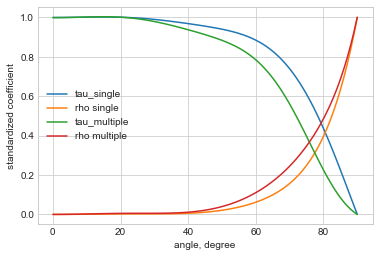

In [6]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

phi = np.arange(start= 0.0, stop= 91.0, step = 1.0)
ax.plot(phi, window.get_tau_d_j_ns(np.radians(phi), 'single'), label='tau_single')
ax.plot(phi, window.get_rho_d_j_ns(np.radians(phi), 'single'), label='rho single')
ax.plot(phi, window.get_tau_d_j_ns(np.radians(phi), 'multiple'), label='tau_multiple')
ax.plot(phi, window.get_rho_d_j_ns(np.radians(phi), 'multiple'), label='rho multiple')

ax.set_xlabel('angle, degree')
ax.set_ylabel('standardized coefficient')

plt.legend()
plt.show()

0.8740957 0.015904299999999982 0.07803235700000002 0.047871942999999945
0.5155324800000001 0.10446751999999992 0.09166964480000023 0.3927978751999997


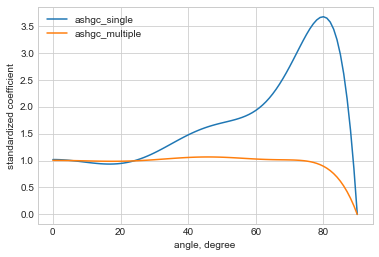

In [7]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

phi = np.arange(start= 0.0, stop= 91.0, step = 1.0)

tau_value, ashgc_value, rho_value, a_value = window.get_tau_and_ashgc_rho_a(eta_w=0.89,
                                                                glazing_type_j='single',
                                                                glass_area_ratio_j=1.0)
print(tau_value, ashgc_value, rho_value, a_value)
ax.plot(phi, window.get_ashgc_d_j(theta_aoi_i_k=np.radians(phi), glazing_type_j='single', tau_w=tau_value, rho_w=rho_value), label='ashgc_single')

tau_value, ashgc_value, rho_value, a_value = window.get_tau_and_ashgc_rho_a(eta_w=0.62,
                                                                glazing_type_j='multiple',
                                                                glass_area_ratio_j=1.0)
print(tau_value, ashgc_value, rho_value, a_value)
ax.plot(phi, window.get_ashgc_d_j(theta_aoi_i_k=np.radians(phi), glazing_type_j='multiple', tau_w=tau_value, rho_w=rho_value), label='ashgc_multiple')

ax.set_xlabel('angle, degree')
ax.set_ylabel('standardized coefficient')

plt.legend()
plt.show()

負荷計算での別知見

In [8]:
def get_tau_satoh(phi: float) -> float:
    """
    Args:
        phi: 入射角, radian
    Returns:
        入射角に対する基準化透過率
    """
    cos_phi = np.cos(phi)
    return (2.392 * cos_phi - 3.8636 * cos_phi ** 3 + 3.7568 * cos_phi ** 5 - 1.3965 * cos_phi ** 7) / 0.88

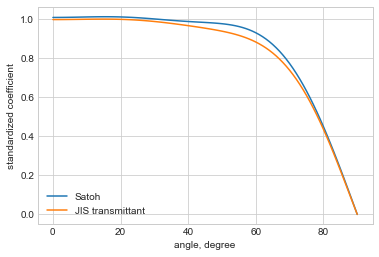

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

phi = np.arange(start= 0.0, stop= 91.0, step = 1.0)
ax.plot(phi, get_tau_satoh(np.radians(phi)), label='Satoh')
ax.plot(phi, window.get_tau_d_j_ns(np.radians(phi), 'single'), label='JIS transmittant')


ax.set_xlabel('angle, degree')
ax.set_ylabel('standardized coefficient')

plt.legend()
plt.show()

### 天空放射に対する規準化透過率

$$ \frac{ \int_0^{\frac{\pi}{2}} \tau(\theta) \cdot 2 \pi \sin \theta \cdot \cos \theta \cdot d \theta }{ \int_0^{\frac{\pi}{2}} 2 \pi \sin \theta \cdot \cos \theta \cdot d \theta } = \frac{ \int_0^{\frac{\pi}{2}} \tau(\theta) \cdot 2 \pi \sin \theta \cdot \cos \theta \cdot d \theta }{ \pi } = \int_0^{\frac{\pi}{2}} \tau(\theta) \cdot \sin 2 \theta \cdot d \theta $$

In [10]:
def get_tau_integral(tau_function: Callable[[float], float], n: int) -> float:

    delta_theta = np.pi / 2 /n

    thetas = np.arange(start=0, stop=np.pi/2, step=delta_theta)
    
    delta_tau = tau_function(thetas) * np.sin(2 * thetas) * delta_theta
    
    return delta_tau.sum()

単層ガラス

In [11]:
get_tau_integral(lambda tau: window.get_tau_d_j_ns(tau, 'single'), n=1000)

0.8968472082254145

In [12]:
window.get_c_d_j(glazing_type_j='single')

0.9

複層ガラス

In [13]:
get_tau_integral(lambda tau: window.get_tau_d_j_ns(tau, 'multiple'), n=1000)

0.8324284946266829

In [14]:
window.get_c_d_j(glazing_type_j='multiple')

0.832

単層ガラス（参考）

In [15]:
get_tau_integral(get_tau_satoh, n=1000)

0.9230277232289603

### 拡散光に対する基準化反射率の計算

#### 単層ガラス

In [16]:
get_tau_integral(lambda tau: window.get_rho_d_j_ns(tau, 'single'), n=1000)

0.06094244591053457

In [17]:
window.get_r_d_j('single')

0.061

#### 複層ガラス

In [18]:
get_tau_integral(lambda tau: window.get_rho_d_j_ns(tau, 'multiple'), n=1000)

0.08841156072394173

In [19]:
window.get_r_d_j('multiple')

0.088

### 拡散光に対する基準化吸収日射取得率の計算

#### 単層ガラス

In [20]:
tau_value, ashgc_value, rho_value, a_value = window.get_tau_and_ashgc_rho_a(eta_w=0.89,
                                                                glazing_type_j='single',
                                                                glass_area_ratio_j=1.0)
get_tau_integral(lambda tau: window.get_ashgc_d_j(glazing_type_j='single', theta_aoi_i_k=tau, tau_w=tau_value, rho_w=rho_value), n=1000)

1.7097620882079725

In [21]:
# 規準化透過率、規準化反射率を桁丸めしているため、３桁目で一致しない
# 桁を増やして一致することを確認済み
print(window.get_c_ashgc(glazing_type_j='single', tau_w=tau_value, rho_w=rho_value))

1.6511025419837244


#### 複層ガラス

In [22]:
tau_value, ashgc_value, rho_value, a_value = window.get_tau_and_ashgc_rho_a(eta_w=0.62,
                                                                glazing_type_j='multiple',
                                                                glass_area_ratio_j=1.0)
print(get_tau_integral(lambda tau: window.get_ashgc_d_j(glazing_type_j='multiple',
                                                        theta_aoi_i_k=tau,
                                                        tau_w=tau_value,
                                                        rho_w=rho_value),
                       n=1000))

1.015480995948065


In [23]:
print(window.get_c_ashgc(glazing_type_j='multiple', tau_w=tau_value, rho_w=rho_value))

1.0169969997393713
